# Mental Health Buddy

Import Data and generate to JSON 

In [20]:
import sqlite3
import pandas as pd
import json

# Verbindung zur SQLite-Datenbank herstellen
conn = sqlite3.connect("database/chatbotanalyse.db")

# Lösche alle Zeilen, in denen 'who_says' 'system' ist
delete_query = "DELETE FROM chatbot_sessions WHERE who_says = 'system'"
conn.execute(delete_query)
conn.commit()  # Wichtig, um die Änderungen zu speichern

# Daten aus einer Tabelle abrufen, annehmen, die Tabelle heißt 'chatbot_sessions'
query = "SELECT * FROM chatbot_sessions ORDER BY user, id"  # Sortierung nach 'user' und 'id' für eine geordnete Abfrage
df = pd.read_sql_query(query, conn)

# Gruppiere nach 'user', der als Sitzungs-ID dient
grouped = df.groupby('user')

conversations_json = {
    "conversations": []
}

for user, group in grouped:
    # Erstelle eine Liste von Nachrichten mit Sender und Text
    conversation = [
        {"sender": "bot" if who_says == "assistant" else "user", "text": text}
        for who_says, text in zip(group['who_says'], group['says_what'])
    ]

    # Erweitere das JSON-Objekt um die konvertierten Nachrichten
    conversations_json['conversations'].append({
        "user": user,
        "conversation": conversation
    })

# Schreibe das erweiterte JSON-Objekt in eine Datei
with open('conversations.json', 'w', encoding='utf-8') as f:
    json.dump(conversations_json, f, ensure_ascii=False, indent=4)

# Topic detection

In [24]:
import json
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim import corpora, models

# Herunterladen der notwendigen NLTK-Ressourcen
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# JSON-Datei laden
with open('conversations.json', 'r') as file:
    data = json.load(file)

# Funktion zur Textverarbeitung
def process_text(text):
    words = word_tokenize(text.lower())
    lemmatizer = WordNetLemmatizer()
    stopped_words = stopwords.words('english')
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopped_words and word.isalpha()]
    return words

# Funktion zur Analyse aller Konversationen
def analyze_all_conversations(conversations):
    texts = []
    for conv in conversations['conversations']:
        for message in conv['conversation']:
            processed_text = process_text(message['text'])
            texts.append(processed_text)
    
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    lda_model = models.LdaModel(corpus, num_topics=3, id2word=dictionary, passes=15)
    return lda_model

# Trainiere das LDA-Modell
lda_model = analyze_all_conversations(data)

 
topics = lda_model.print_topics(num_words=4)
for topic_no, topic in enumerate(topics):
    print(f"Topic {topic_no + 1}: {topic}")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tbann\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tbann\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tbann\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Topic 1: (0, '0.018*"remember" + 0.016*"help" + 0.015*"feeling" + 0.013*"anxiety"')
Topic 2: (1, '0.014*"take" + 0.014*"remember" + 0.013*"feeling" + 0.013*"help"')
Topic 3: (2, '0.012*"take" + 0.010*"study" + 0.010*"feel" + 0.010*"remember"')


# Interpretation

Here, the Latent Dirichlet Allocation (LDA) model was used to identify the dominant topics within the collected conversations. 
They provide insight into the focus of various discussion topics identified in the dataset. Each row represents a topic and shows the top four words and their relative weights within that topic. Here is an interpretation of each topic based on the weights:

### Topic 1:
- words: remember (0.018), help (0.016), feeling (0.015), anxiety (0.013)
- Topic name: Emotional support and anxiety
- Interpretation: This topic deals includes a conversation about memories and support. It seems to be about topics concerning personal support and emotional health.

### Topic 3: 
- words: take (0.014), remember (0.014), feeling (0.013), help (0.013)
- Topic name: Personal development and support
- Interpretation: This topic centres more about taking action, remembering important things or seeking emotional support.

### Topic 2: 
- words: take (0.012), study (0.010), feel (0.010), remember (0.010)
- Topic name: Education and emotional well-being
- Interpretation: This topic could relate to education combined with personal feelings. The words indicate discussions that may be related to studies, but also have an emotional component.

### Understanding weight:
The weights (e.g. 0.018, 0.016) represent the probability that the respective word occurs in the specific topic. A higher weight means that the word has a stronger representation in this topic and is considered more important for the topic. 

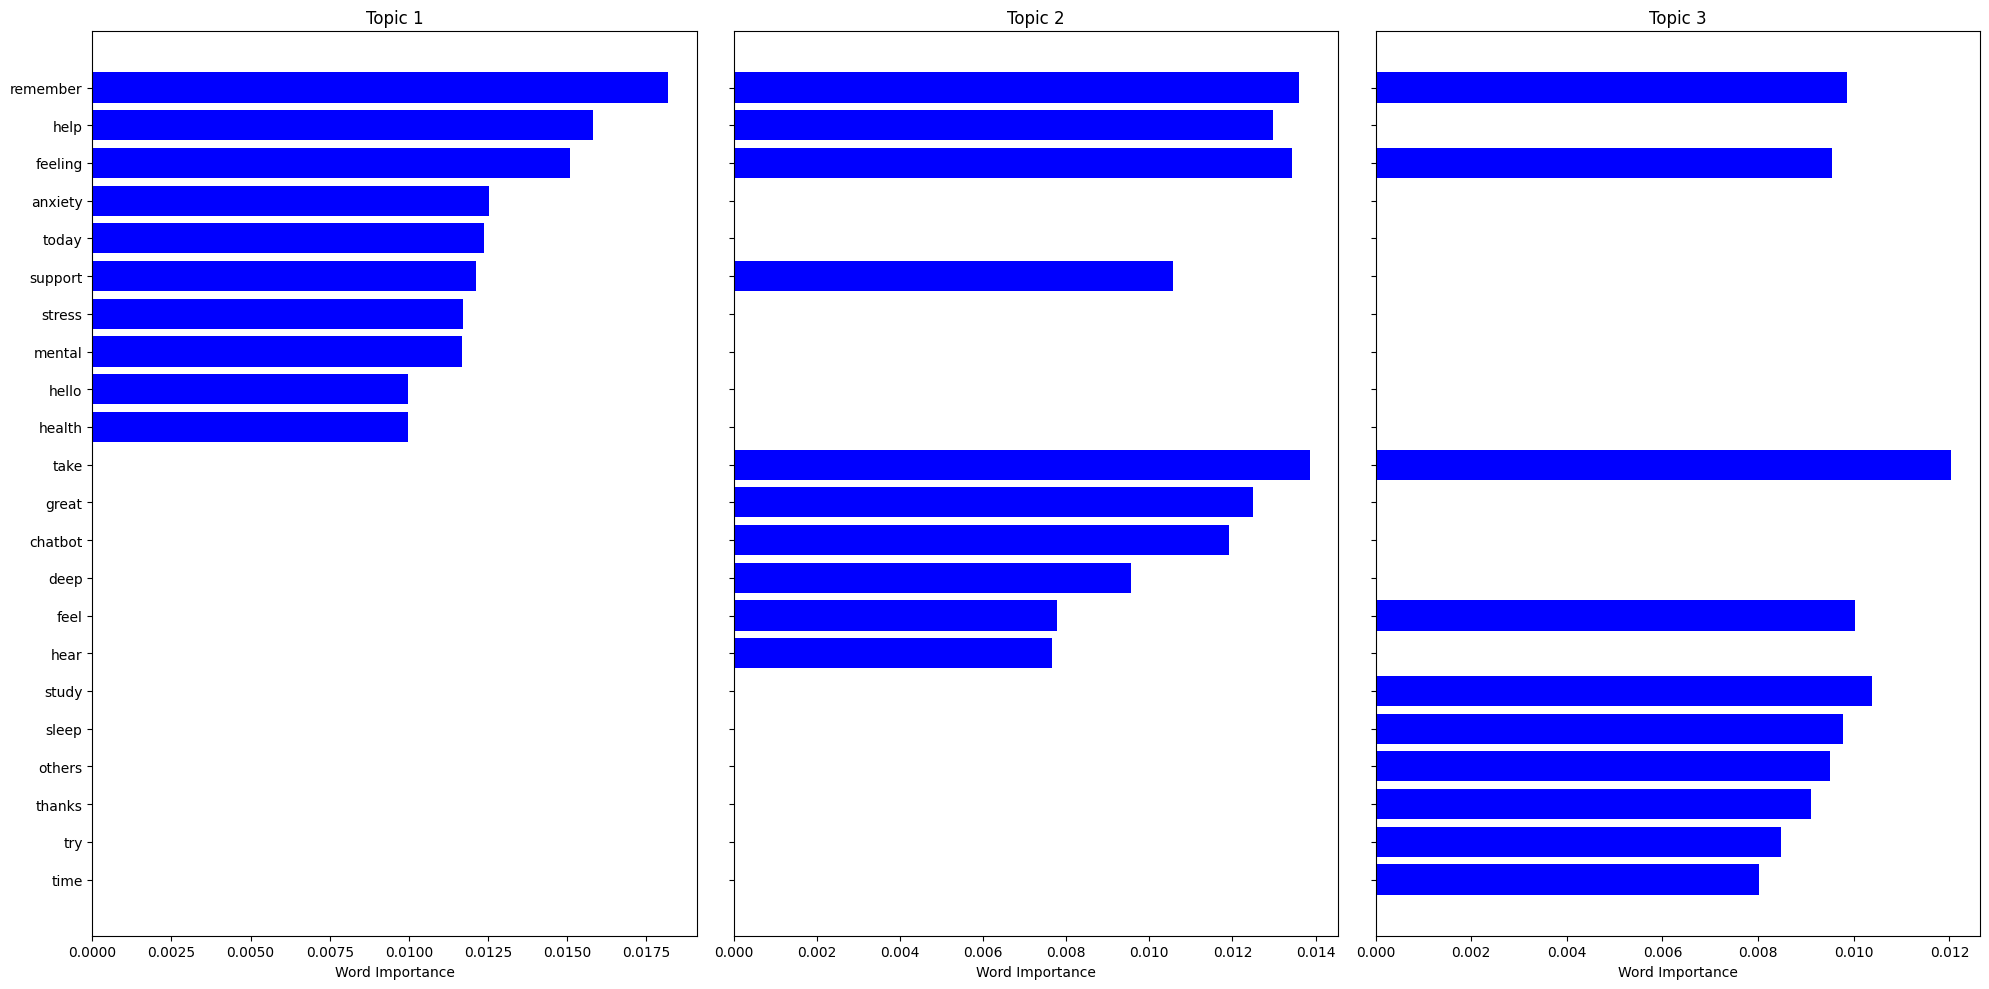

In [25]:
import matplotlib.pyplot as plt

# Funktion zur Darstellung der wichtigsten Wörter pro Thema
def plot_top_words(lda_model, num_topics, num_words=10):
    keywords = [[word for word, _ in lda_model.show_topic(topic_id, topn=num_words)] for topic_id in range(num_topics)]
    weights = [[weight for _, weight in lda_model.show_topic(topic_id, topn=num_words)] for topic_id in range(num_topics)]

    fig, axes = plt.subplots(1, num_topics, figsize=(20, 10), sharey=True)
    axes = axes.flatten()
    
    for i in range(num_topics):
        ax = axes[i]
        ax.barh(keywords[i], weights[i], color='blue')
        ax.set_title(f'Topic {i + 1}')
        ax.invert_yaxis()
        ax.set_xlabel('Word Importance')
        
    plt.tight_layout()
    plt.show()

# Aufrufen der Funktion mit dem LDA-Modell
plot_top_words(lda_model, num_topics=3, num_words=10)


# Interpretation

The visualised barplots show the top 10 keywords for each of the three topics extracted from your Latent Dirichlet Allocation (LDA) model. The length of the bars represents the importance or weight of each word within each topic. Here is an interpretation for each topic based on the visible keywords:

### Topic overview
- **Topic 1**: Focuses on personal well-being or psychological support.
- **Topic 2**: This topic addresses personal emotional support. 
- **Topic 3**: The focus of this topic is similar to topic 2, focusing on personal wellbeing, but has a stronger link to study and time management.

# Sentiment analysis

VADER (Valance Aware Dictionary and Sentiment Reasoner) for the sentiment analysis

In [56]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import json

# Voraussetzung: NLTK-Ressourcen müssen geladen sein
nltk.download('vader_lexicon')

# Funktion, um Sentiment für jede Nachricht zu analysieren
def analyze_sentiment_vader(conversations):
    sid = SentimentIntensityAnalyzer()
    results = []

    for conversation in conversations:
        for message in conversation['conversation']:
            text = message['text']
            sentiment_scores = sid.polarity_scores(text)
            results.append({
                "user": conversation["user"],
                "text": text,
                "sentiment": sentiment_scores
            })
    return results

# JSON-Datei laden, die die Konversationen enthält
with open('conversations.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

# Sentiment-Analyse durchführen
sentiment_results = analyze_sentiment_vader(data['conversations'])

# Ergebnisse ausgeben oder weiterverarbeiten
for result in sentiment_results:
    print(result)



{'user': '394dc8fa-ca55-4fe3-83d4-bf9f64754e99', 'text': "Hello! 😊 How are you feeling today? Are you ready to talk? I'm your Mental Health Buddy here to help you cope with stress and anxiety. Let's work through it together! 🤗💪", 'sentiment': {'neg': 0.118, 'neu': 0.682, 'pos': 0.2, 'compound': 0.4843}}
{'user': '394dc8fa-ca55-4fe3-83d4-bf9f64754e99', 'text': 'Ok. Lets do it!', 'sentiment': {'neg': 0.0, 'neu': 0.546, 'pos': 0.454, 'compound': 0.3595}}
{'user': '394dc8fa-ca55-4fe3-83d4-bf9f64754e99', 'text': "That's the spirit! 🎉 What's been on your mind lately? Any specific challenges or stressors you'd like to discuss? Remember, you're not alone in this. I'm here to listen and support you. 😊👂", 'sentiment': {'neg': 0.078, 'neu': 0.655, 'pos': 0.267, 'compound': 0.6696}}
{'user': '394dc8fa-ca55-4fe3-83d4-bf9f64754e99', 'text': 'Thanks for asking. My girlfriend is very stressed since a few weeks. The semester is coming to an end and she has a lot of assignments and exams. How can I help

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\tbann\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Visualisation for VADER

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\tbann\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


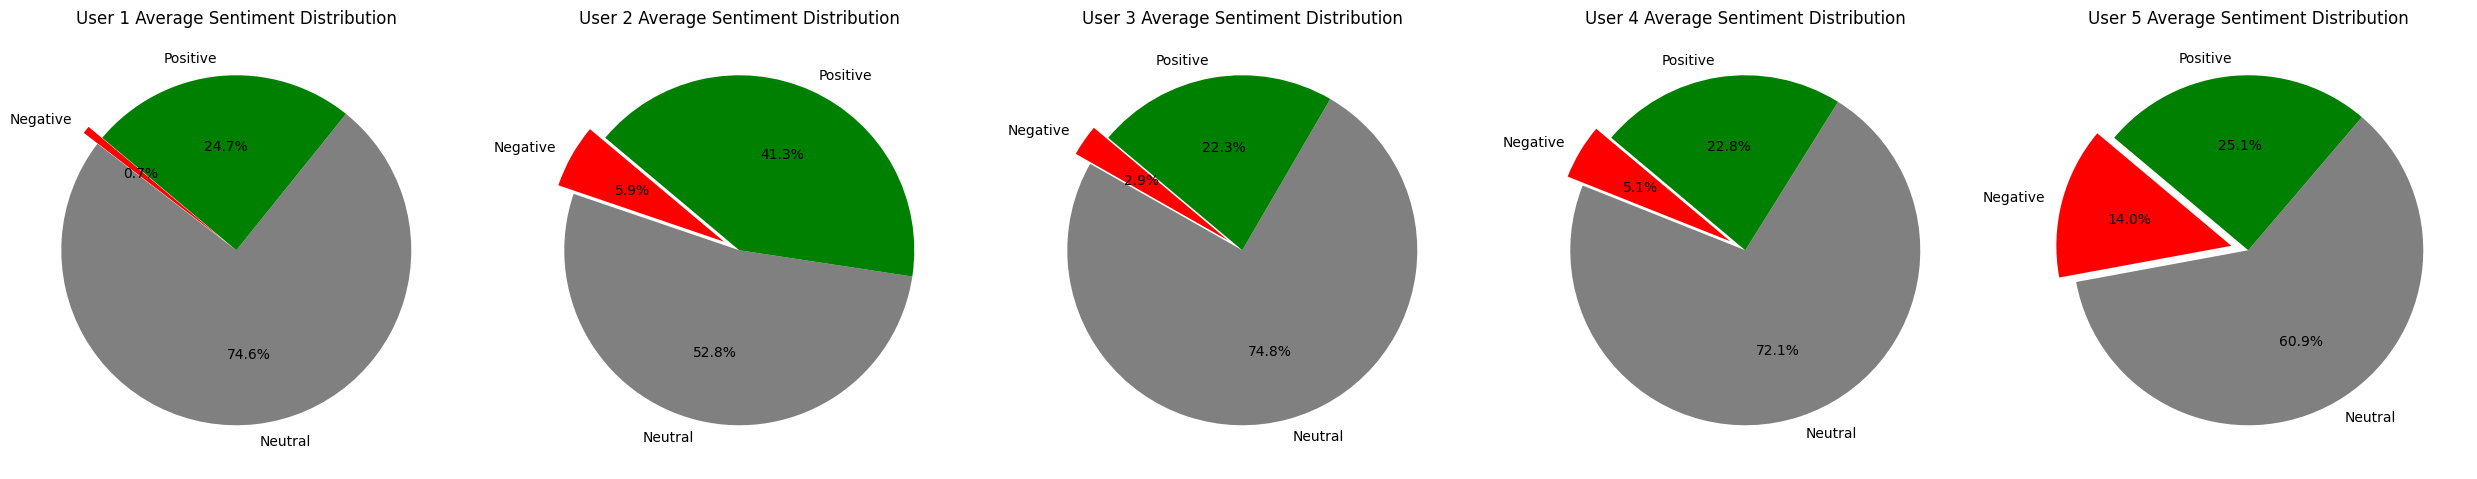

In [58]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# NLTK Ressourcen herunterladen, falls noch nicht geschehen
nltk.download('vader_lexicon')

# Verbindung zur SQLite-Datenbank herstellen
conn = sqlite3.connect("database/chatbotanalyse.db")

# Daten aus der Datenbank abfragen
query = "SELECT * FROM chatbot_sessions WHERE who_says = 'user' ORDER BY user, id"
df = pd.read_sql_query(query, conn)

# Initialisierung des VADER Sentiment Analyzers
sid = SentimentIntensityAnalyzer()

# Anwenden der Sentiment-Analyse auf jede Nachricht
df['sentiments'] = df['says_what'].apply(lambda text: sid.polarity_scores(text))
df[['neg', 'neu', 'pos', 'compound']] = df['sentiments'].apply(pd.Series)

# Schließen der Datenbankverbindung
conn.close()

# Gruppieren der Daten nach Benutzer
grouped = df.groupby('user')

# Erstellen eines Pie-Charts für jeden Benutzer
user_count = 1  # Zähler für die Benutzernummerierung
fig, axes = plt.subplots(1, len(grouped), figsize=(25, 5))  # Stellen Sie sicher, dass genug Platz für alle Pie-Charts ist

for (_, group), ax in zip(grouped, axes.flatten()):
    average_sentiments = group[['neg', 'neu', 'pos']].mean()
    colors = ['red', 'gray', 'green']  # Farben für die Segmente
    explode = (0.1, 0, 0)  # Nur das erste Segment leicht hervorheben
    ax.pie(average_sentiments, labels=['Negative', 'Neutral', 'Positive'], autopct='%1.1f%%', startangle=140, colors=colors, explode=explode)
    ax.set_title(f'User {user_count} Average Sentiment Distribution')
    user_count += 1  # Erhöhe den Benutzerzähler für die nächste Beschriftung

plt.tight_layout()
plt.show()


# Interpretation for all 5 users

The pie charts show the average distribution of sentiments for five different users based on their conversations. Here is an interpretation for each pie chart:

### User 1
**Positive:** 25%  
**Negative:** 0.7%   
**Neutral:** 75%   
**Interpretation:**   
The majority of communication is neutral, with a medium proportion of positive statements and a very low proportion of negative statements. This could indicate that the interactions are objectiv or informative, without strong emotional swings.

### User 2
**Positive:** 41%  
**Negative:** 6%  
**Neutral:** 53%  
**Interpretation:**   
This user shows a more balanced distribution of positive and neutral comments, which could indicate an overall positive experience. 

### User 3
**Positive:** 22%  
**Negative:** 3%  
**Neutral:** 75%  
**Interpretation:**   
Similar to User 1, neutral comments dominate here too, supplemented by a reasonable proportion of positive feedback. The low proportion of negative comments highlights a few problems or challenges.

### User 4
**Positive:** 23%  
**Negative:** 5%  
**Neutral:** 72%  
**Interpretation:**   
This user's communication is mainly neutral with a similar distribution of positive comments as user 3, but with a slightly higher proportion of negative comments. This could indicate more frequent unhappiness or critical points in the interactions.

### User 5
**Positive:** 25%  
**Negative:** 14%  
**Neutral:** 61%  
**Interpretation:**    
User 5 shows the highest proportion of negative comments among all users, which indicates significant problems or dissatisfaction. The proportion of positive comments remains relevant, suggesting a mixed experience.

# Sentiment analysis for the bot's responses

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\tbann\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


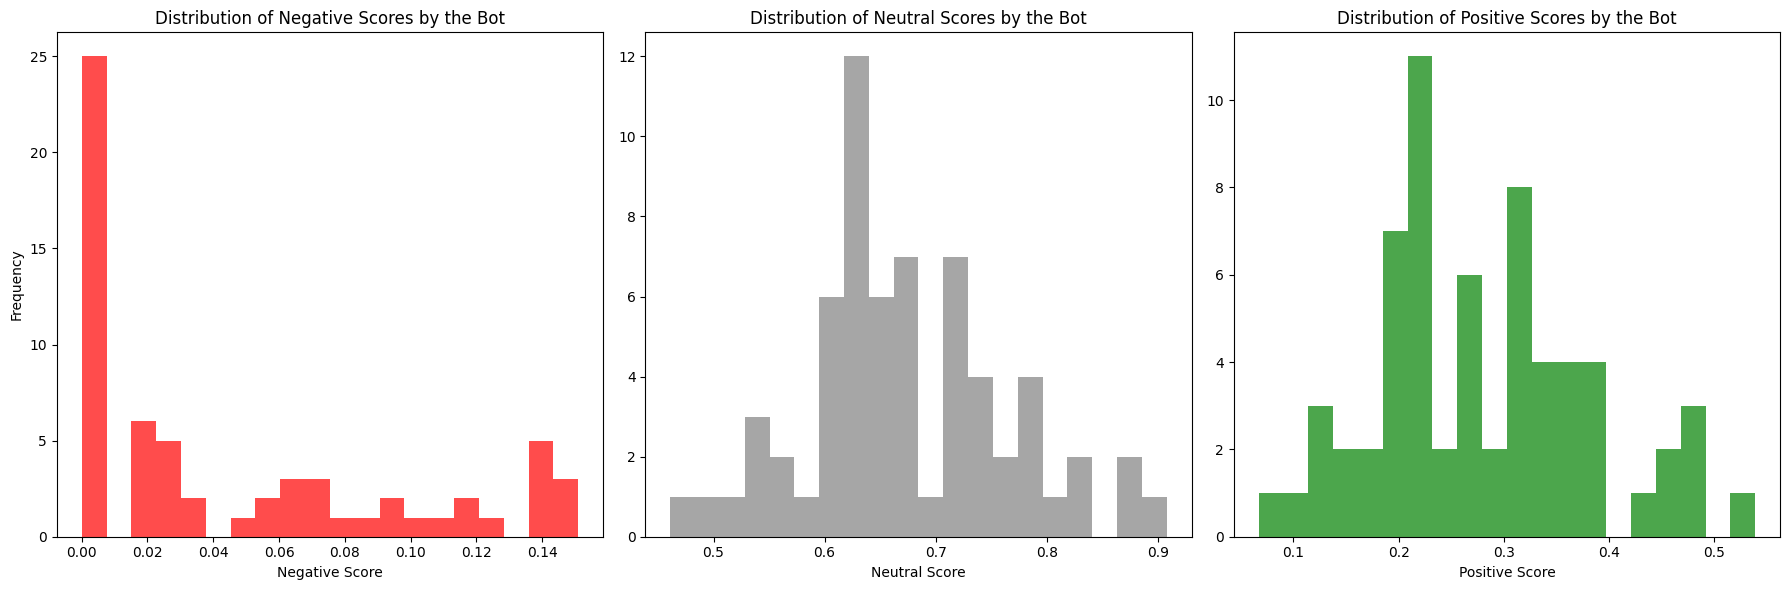

In [59]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# NLTK Ressourcen herunterladen
nltk.download('vader_lexicon')

# Verbindung zur SQLite-Datenbank herstellen
conn = sqlite3.connect("database/chatbotanalyse.db")

# Daten aus der Datenbank abfragen
query = "SELECT * FROM chatbot_sessions WHERE who_says = 'assistant' ORDER BY user, id"
df = pd.read_sql_query(query, conn)

# Initialisierung des VADER Sentiment Analyzers
sid = SentimentIntensityAnalyzer()

# Anwenden der Sentiment-Analyse auf jede Nachricht
df['sentiments'] = df['says_what'].apply(lambda text: sid.polarity_scores(text))
df[['neg', 'neu', 'pos', 'compound']] = df['sentiments'].apply(pd.Series)

# Schließen der Datenbankverbindung
conn.close()

# Visualisierung der Sentiment-Werte als Histogramme
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Histogramm für negative Scores
axes[0].hist(df['neg'], bins=20, color='red', alpha=0.7)
axes[0].set_title('Distribution of Negative Scores by the Bot')
axes[0].set_xlabel('Negative Score')
axes[0].set_ylabel('Frequency')

# Histogramm für neutrale Scores
axes[1].hist(df['neu'], bins=20, color='gray', alpha=0.7)
axes[1].set_title('Distribution of Neutral Scores by the Bot')
axes[1].set_xlabel('Neutral Score')

# Histogramm für positive Scores
axes[2].hist(df['pos'], bins=20, color='green', alpha=0.7)
axes[2].set_title('Distribution of Positive Scores by the Bot')
axes[2].set_xlabel('Positive Score')

plt.tight_layout()
plt.show()


# Interpretation Bot responses

The histograms visualise the distribution of sentiment scores generated by the VADER Sentiment Analyzer for messages sent by the chatbot. Each histogram represents a different sentiment category: negative, neutral and positive. Here are the interpretations for each histogram:

### Negativ score:
**Interpretation:**      
The majority of messages have very low negative scores, with a high frequency of 0, meaning that most bot messages express little or no negative emotion. The bot has been programmed to communicate primarily neutrally or positively, as this view shows. 

### Neutral score:
**Interpretation:**     
The distribution of neutral scores is more widely spread, with a peak between 0.6 and 0.7. This shows that many of the bot's messages are categorised as mostly neutral.
The wide distribution means that the bot reacts objectively to a large number of requests without provoking strong emotional reactions.

### Positiv score:
**Interpretation:** 
The positive score distribution shows several peaks between 0.1 and 0.4, showing that the bot communicates with positive emotions to keep the communication pleasant and positive.

# Sentiment analysis for the user's responses

In [ ]:
import sqlite3
import pandas as pd
import json

# Verbindung zur SQLite-Datenbank herstellen
conn = sqlite3.connect("database/chatbotanalyse.db")

# Lösche alle Zeilen, in denen 'who_says' 'system' ist
delete_query = "DELETE FROM chatbot_sessions WHERE who_says = 'system'"
conn.execute(delete_query)
conn.commit()  # Wichtig, um die Änderungen zu speichern

# Daten aus einer Tabelle abrufen, annehmen, die Tabelle heißt 'chatbot_sessions'
query = "SELECT * FROM chatbot_sessions ORDER BY user, id"  # Sortierung nach 'user' und 'id' für eine geordnete Abfrage
df = pd.read_sql_query(query, conn)

# Gruppiere nach 'user', der als Sitzungs-ID dient
grouped = df.groupby('user')

conversations_json = {
    "conversations": []
}

for user, group in grouped:
    # Erstelle eine Liste von Nachrichten mit Sender und Text
    conversation = [
        {"sender": "bot" if who_says == "assistant" else "user", "text": text}
        for who_says, text in zip(group['who_says'], group['says_what'])
    ]

    # Erweitere das JSON-Objekt um die konvertierten Nachrichten
    conversations_json['conversations'].append({
        "user": user,
        "conversation": conversation
    })

# Schreibe das erweiterte JSON-Objekt in eine Datei
with open('conversations.json', 'w', encoding='utf-8') as f:
    json.dump(conversations_json, f, ensure_ascii=False, indent=4)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\tbann\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


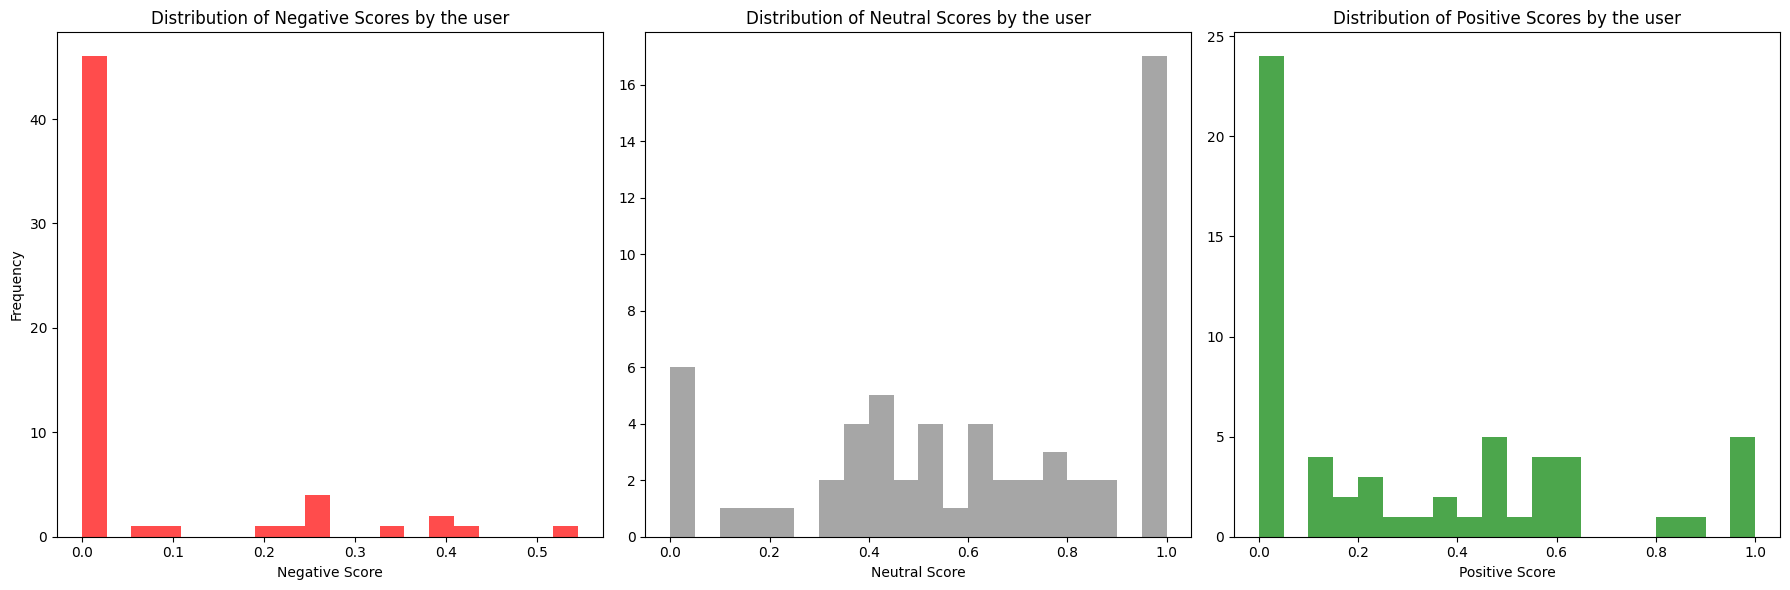

In [61]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# NLTK Ressourcen herunterladen
nltk.download('vader_lexicon')

# Verbindung zur SQLite-Datenbank herstellen
conn = sqlite3.connect("database/chatbotanalyse.db")

# Daten aus der Datenbank abfragen, diesmal nur für 'user' Nachrichten
query = "SELECT * FROM chatbot_sessions WHERE who_says = 'user' ORDER BY user, id"
df = pd.read_sql_query(query, conn)

# Initialisierung des VADER Sentiment Analyzers
sid = SentimentIntensityAnalyzer()

# Anwenden der Sentiment-Analyse auf jede Nachricht
df['sentiments'] = df['says_what'].apply(lambda text: sid.polarity_scores(text))
df[['neg', 'neu', 'pos', 'compound']] = df['sentiments'].apply(pd.Series)

# Schließen der Datenbankverbindung
conn.close()

# Visualisierung der Sentiment-Werte als Histogramme
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Histogramm für negative Scores
axes[0].hist(df['neg'], bins=20, color='red', alpha=0.7)
axes[0].set_title('Distribution of Negative Scores by the user')
axes[0].set_xlabel('Negative Score')
axes[0].set_ylabel('Frequency')

# Histogramm für neutrale Scores
axes[1].hist(df['neu'], bins=20, color='gray', alpha=0.7)
axes[1].set_title('Distribution of Neutral Scores by the user')
axes[1].set_xlabel('Neutral Score')

# Histogramm für positive Scores
axes[2].hist(df['pos'], bins=20, color='green', alpha=0.7)
axes[2].set_title('Distribution of Positive Scores by the user')
axes[2].set_xlabel('Positive Score')

plt.tight_layout()
plt.show()


# Interpretation:

The histograms visualise the distribution of sentiment scores generated by the VADER Sentiment Analyzer for messages sent by the chatbot. Each histogram represents a different sentiment category: negative, neutral and positive. Here are the interpretations for each histogram:


### Negativ score:
**Interpretation:**      
The majority of user messages have a negative score of 0, which indicates a low number of negative messages. This means that users are either satisfied with the chatbot or that negative emotions are not strongly expressed.

### Neutral score:
**Interpretation:**     
A significant proportion of messages have high neutral scores, particularly in the range of 0.9 and 1.0. The high frequency of neutral scores could indicate that many user requests are information-orientated communication.

### Positiv score:
**Interpretation:** 
The majority of user messages have a positive score of 0, there are also several smaller peaks at higher values. The distribution shows that many messages have slight positive tendencies, while more positively charged messages are less frequent.

# Stress level

In [71]:
import json
import re

# Daten laden
with open('conversations.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

# Datenextraktion
responses = []
for conversation in data['conversations']:
    previous_message_scale = False  # Tracker, ob die vorherige Nachricht eine Skalenfrage war
    for message in conversation['conversation']:
        text_lower = message['text'].lower()
        # Überprüfen, ob die aktuelle Nachricht die Skalenfrage stellt
        if "scale of 1 to 10" in text_lower or "rate your mood" in text_lower:
            previous_message_scale = True
        elif previous_message_scale and message['sender'] == 'user':  # Überprüfen, ob es die Antwort des Nutzers ist
            responses.append({
                'user': conversation['user'],
                'question': previous_message,  # Speichern der vorherigen Frage
                'response': message['text']  # Speichern der Nutzerantwort
            })
            previous_message_scale = False  # Zurücksetzen des Trackers
        previous_message = message['text']  # Aktualisieren der letzten Nachricht für den Kontext

# Ausgabe der Ergebnisse
for response in responses:
    print(f"User: {response['user']}")
    print(f"Question: {response['question']}")
    print(f"Response: {response['response']}\n")



User: 50671dbd-226e-4bc1-94ef-b651b3e521cf
Question: That's great to hear! 😄 How have you been feeling lately? On a scale of 1-10, how would you rate your mood today? Remember, I'm here to support you! 😊🌷
Response: I am on a 10 today, feeling wonderful!

User: dea56154-201d-46c7-98eb-d3989fe4a431
Question: That's great to hear! So, how are you feeling today on a scale of 1 to 10? Remember, 1 is low and 10 is amazing! 😄🌟
Response: 5



# Engagement

In [70]:
import sqlite3
import pandas as pd
from collections import defaultdict
from datetime import datetime

# Verbindung zur SQLite-Datenbank herstellen
conn = sqlite3.connect("database/chatbotanalyse.db")

# SQL-Abfrage zum Auswählen der erforderlichen Daten
query = """
SELECT user, t as timestamp, says_what, who_says
FROM chatbot_sessions
ORDER BY timestamp;
"""

# Die Abfrage ausführen und die Daten in ein Pandas DataFrame laden
df = pd.read_sql_query(query, conn)


# Initialisierung eines Dictionaries zur Zählung der Interaktionen pro Tag
daily_interactions = defaultdict(int)

# Durchlaufen jedes Datensatzes im DataFrame, um Nachrichten nach Datum zu zählen
for index, row in df.iterrows():
    # Den Zeitstempel-String in ein datetime-Objekt konvertieren
    timestamp = datetime.strptime(row['timestamp'], "%Y-%m-%d %H:%M:%S")
    date_str = timestamp.date().isoformat()  # Das datetime-Objekt in einen Datum-String konvertieren
    daily_interactions[date_str] += 1

# Die Anzahl der täglichen Interaktionen ausgeben
for date, count in sorted(daily_interactions.items()):
    print(f"Datum: {date} - Interaktionen: {count}")


Datum: 2024-05-27 - Interaktionen: 67
Datum: 2024-05-28 - Interaktionen: 46
Datum: 2024-05-29 - Interaktionen: 10
